In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file_names=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        file_names.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
dataset=file_names[0]
file_names=file_names[1:]


In [4]:
print(len(file_names))

2204


In [5]:
#now lets print the dataset.csv file
dataset=pd.read_csv(dataset)
dataset

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158
3346,00002232.jpg,620,349,122,103,344,248
3347,00002232.jpg,620,349,258,118,541,303
3348,00002232.jpg,620,349,215,11,362,108


In [6]:
print(dataset["image_name"][2206])

00000280.jpg


There are multiple detections in an image 

In [7]:
#now lets convert the information into a dictionary
dataset_dictionary={}
for i in range(len(dataset)):
    parameters=[]
    for j in dataset.columns:
        if j!='image_name':
            parameters.append(dataset[j][i])
    dataset_dictionary[dataset['image_name'][i]]=parameters
    

In [8]:
key_values=[]

for key in dataset_dictionary.keys():
    key_values.append(key)
key_values=set(key_values)

print(len(key_values))
        

2204


In [9]:
import cv2

def standardize_image(list1):
    for i in range(len(list1)):
        old_image=cv2.imread(list1[i])
        
        new_image=cv2.resize(old_image,(224,224),interpolation=cv2.INTER_AREA)
        
        return new_image
        

In [ ]:
#here we  need to preprocess the image 


The object detection model has two parts

The classification model                     
The regression model for the bounding box


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense

class ObjectDetectorModel:
    def __init__(self):
        self.classifier_model = None
        self.regressor_model = None

    def classifier(self):
        classifier_model = Sequential()
        classifier_model.add(Input(shape=(224, 224, 3)))

        classifier_model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
        classifier_model.add(AveragePooling2D(2,2))
        classifier_model.add(Conv2D(16, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
        classifier_model.add(AveragePooling2D(2,2))
        classifier_model.add(Conv2D(8, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
        classifier_model.add(AveragePooling2D(2,2))
        classifier_model.add(Conv2D(1, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
        classifier_model.add(AveragePooling2D(2,2))

        classifier_model.add(Flatten())
        classifier_model.add(Dense(100, activation='relu'))
        classifier_model.add(Dense(20, activation='relu'))
        classifier_model.add(Dense(2, activation='softmax'))

        self.classifier_model = classifier_model
        return classifier_model

    def regressor(self):
        regressor_model = Sequential()
        regressor_model.add(Input(shape=(224, 224, 3)))
        
        regressor_model.add(Conv2D(10, kernel_size=(3, 3), padding='same', activation='relu'))
        regressor_model.add(AveragePooling2D(2,2))
        regressor_model.add(Conv2D(8, kernel_size=(3, 3), padding='same', strides=(3, 3), activation='relu'))
        regressor_model.add(AveragePooling2D(2,2))
        regressor_model.add(Conv2D(4, kernel_size=(3, 3), padding='same', strides=(3, 3), activation='relu'))
        regressor_model.add(AveragePooling2D(2,2))
        regressor_model.add(Conv2D(1, kernel_size=(3, 3), padding='same', strides=(3, 3), activation='relu'))
        regressor_model.add(AveragePooling2D(2,2))
        regressor_model.add(Flatten())

        regressor_model.add(Dense(100, activation='relu'))
        regressor_model.add(Dense(20, activation='relu'))
        regressor_model.add(Dense(4, activation='linear'))

        self.regressor_model = regressor_model
        return regressor_model

    def final_model(self):
        input_layer = Input(shape=(224, 224, 3))
        
        # Call the methods to create and return the models
        classifier_model = self.classifier()
        regressor_model = self.regressor()

        classifier_output = classifier_model(input_layer)
        regressor_output = regressor_model(input_layer)

        self.final_output = Model(inputs=input_layer, outputs=[classifier_output, regressor_output])
        return self.final_output


2024-07-30 14:57:07.060747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 14:57:07.060905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 14:57:07.199814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


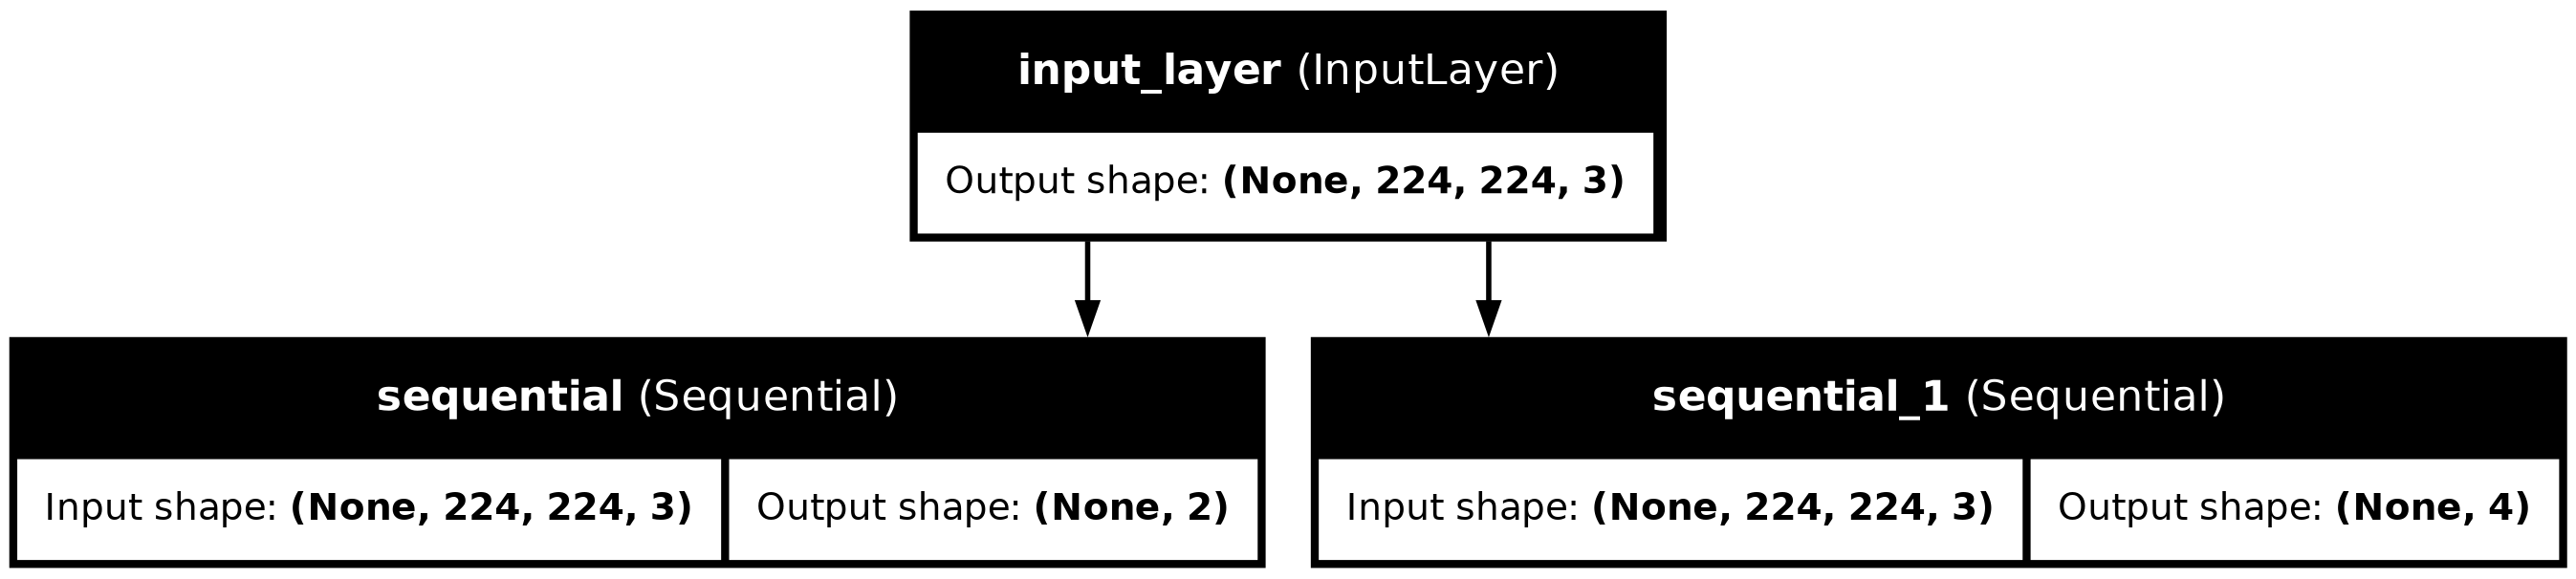

In [11]:
# Usage
model = ObjectDetectorModel()
final_model = model.final_model()

# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(final_model, show_layer_names=True, show_shapes=True)
